## Figure 4: The fibrotic potential of short-telomere pulmonary fibrosis BAL macrophages

In [3]:
library(Seurat)  
library(ggplot2)  
library(dplyr)    
library(tidyr)    
library(ggrepel)  
library(scProportionTest) 
library(edgeR)     
library(scales) 
set.seed(1) 

options(repr.plot.width = 25, repr.plot.height = 15)
options(ggrepel.max.overlaps = Inf)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma



In [1]:
# Load Seurat Object
bal <- readRDS("BAL_FINAL.rds")

In [2]:
# subset out only samples with telomere length information
telo <- subset(bal, telomere_length != "NA")

# subset out only the monocyte-like macrophages
telo.macs <- subset(telo, Cell_Subtype == "Monocyte-like macrophage")
telo.macs@meta.data$telomere_length <- droplevels(telo.macs@meta.data$telomere_length)

## Figure 4a,b: Cell type proportion analysis of monocyte-like macrophage subclusters by telomere length, in all ILD subtypes and in IPF only

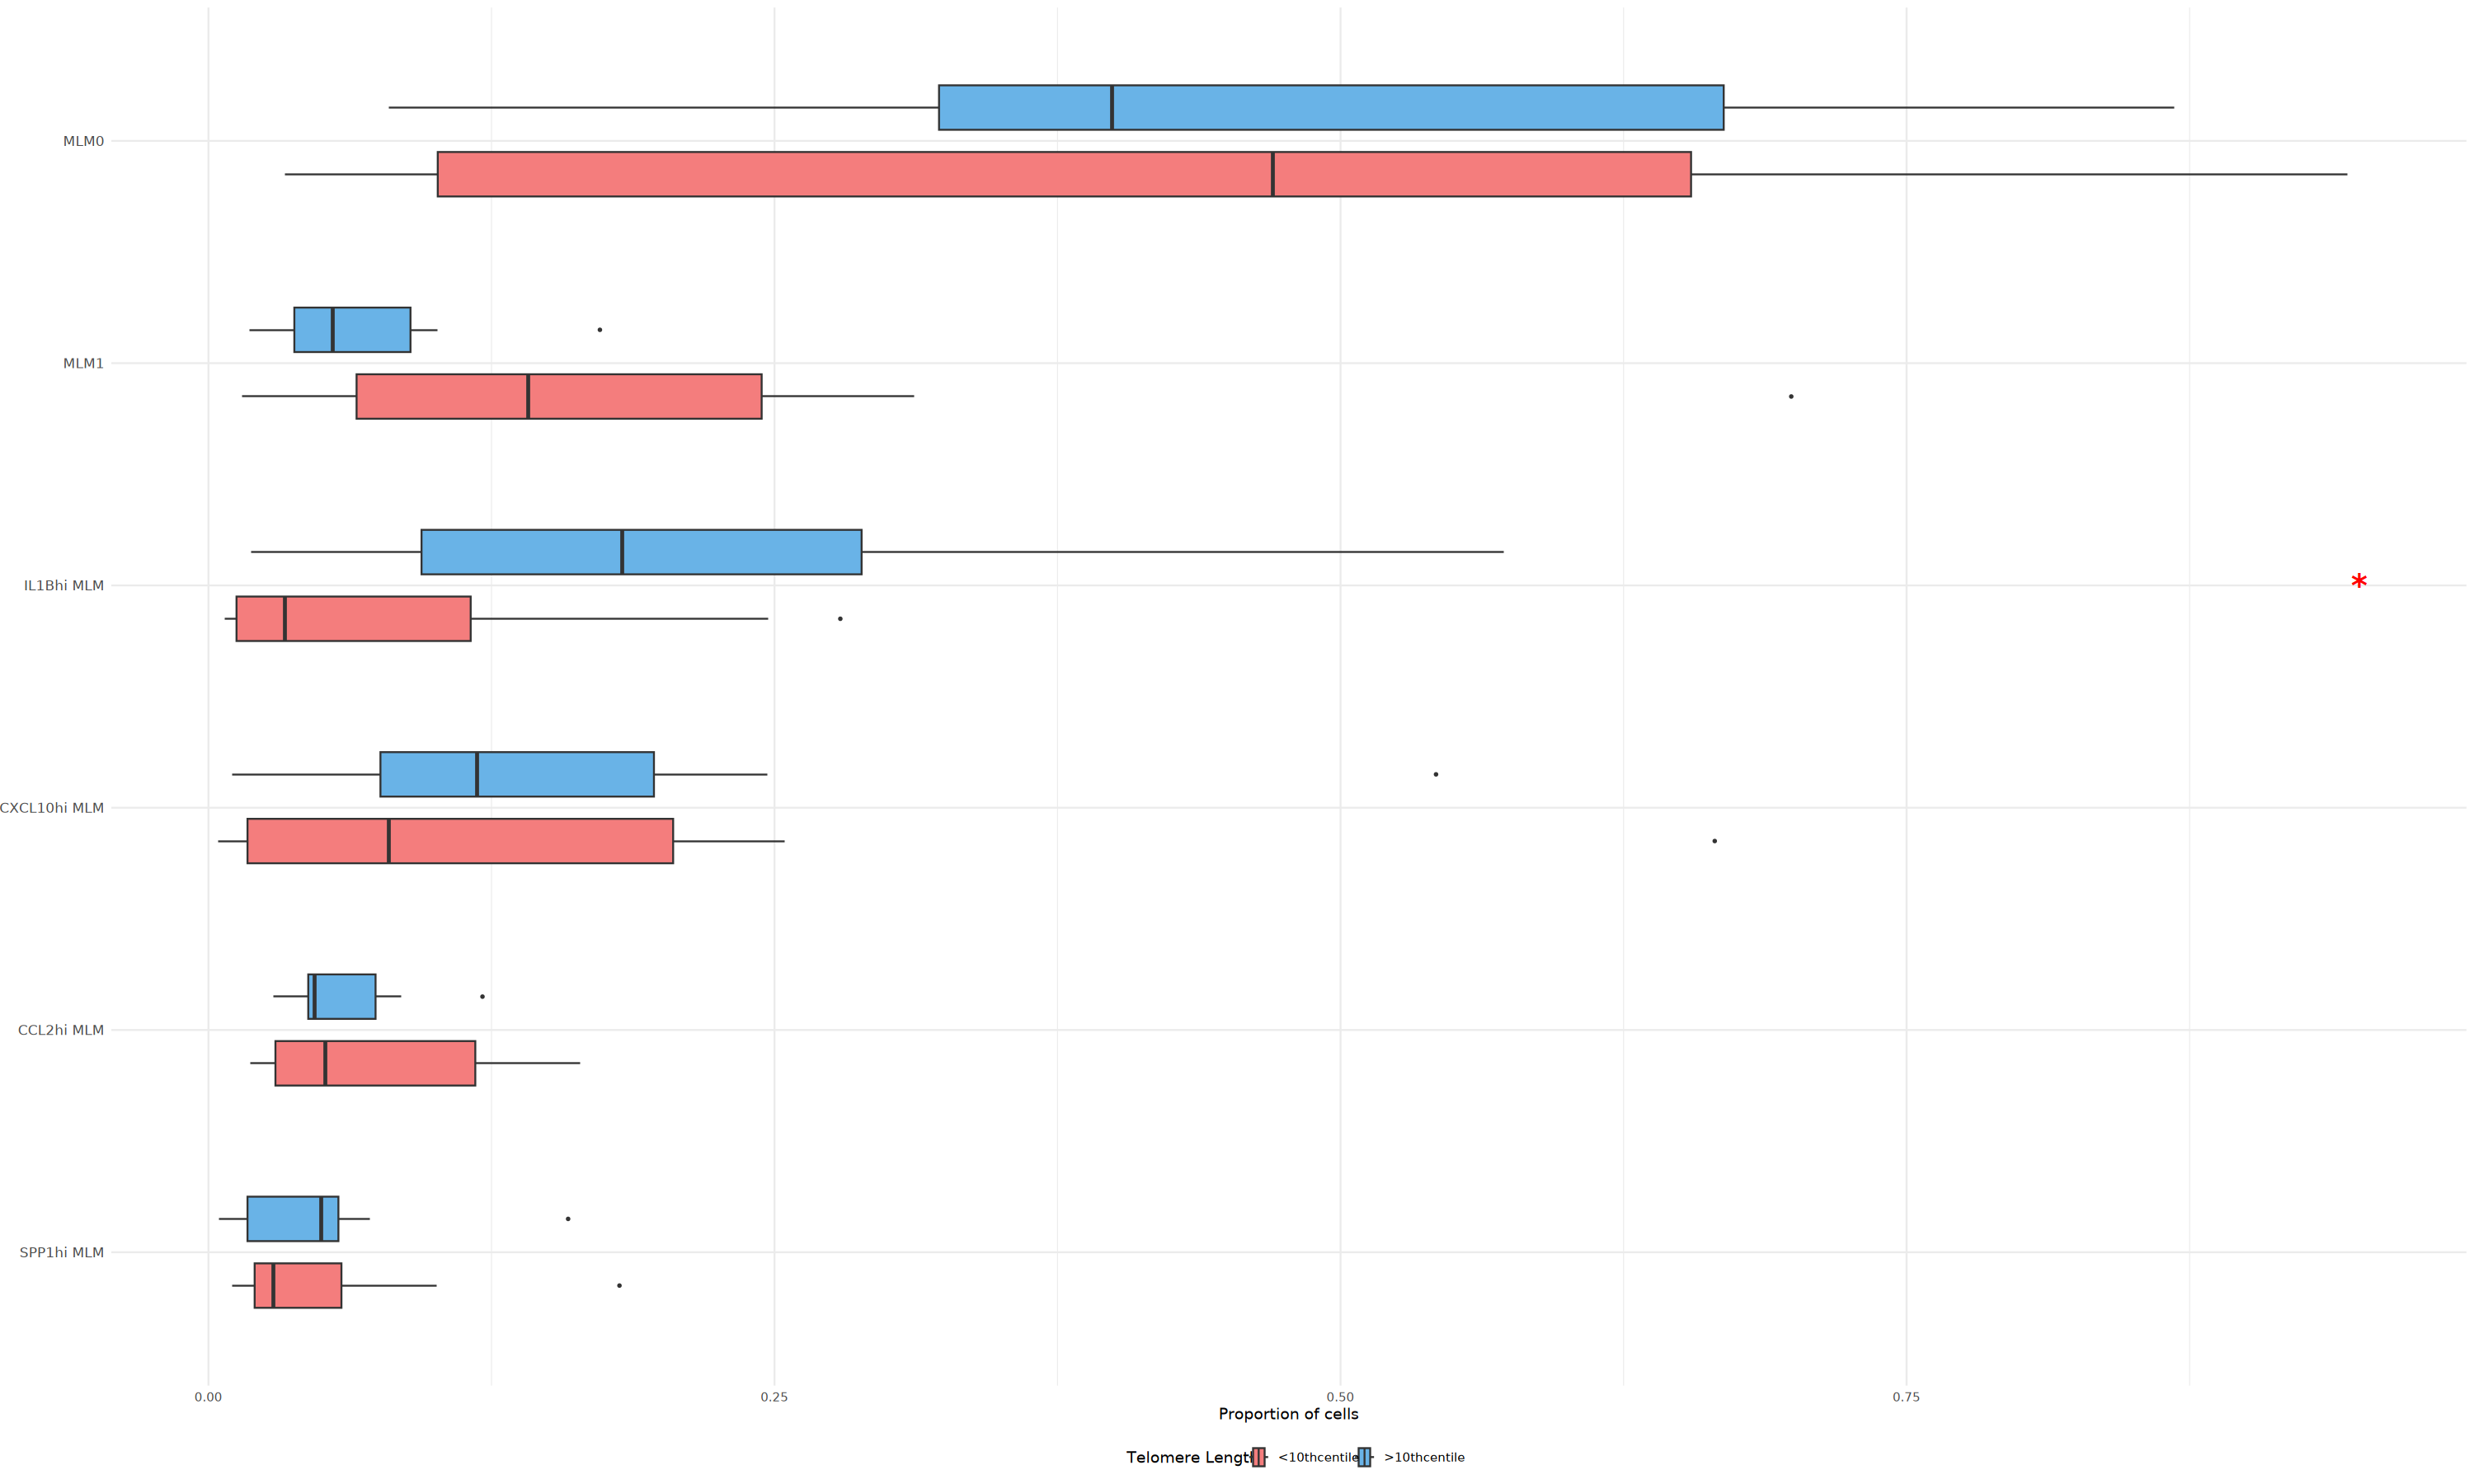

In [5]:
# in all ILD samples:
metadata <- telo.macs@meta.data

# Calculate proportion per cell subtype and telomere length group
prop_data <- metadata %>%
  group_by(Sample, telomere_length, Cell_Sub_subtype) %>%
  summarise(count = n(), .groups = "drop") %>%
  group_by(Sample, telomere_length) %>%
  mutate(proportion = count / sum(count)) %>%
  ungroup()

custom_order <- rev(c("MLM0", "MLM1", "IL1Bhi MLM", "CXCL10hi MLM", "CCL2hi MLM", "SPP1hi MLM"))
prop_data$Cell_Sub_subtype <- factor(prop_data$Cell_Sub_subtype, levels = custom_order)

# Create a data frame for significance markers
p_values <- prop_data %>%
  group_by(Cell_Sub_subtype) %>%
  summarise(
    p_value = wilcox.test(
      proportion[telomere_length == "<10thcentile"],
      proportion[telomere_length == ">10thcentile"]
    )$p.value
  ) %>%
  filter(p_value < 0.05) 

# Create the significance data frame 
significance_data <- p_values %>%
  mutate(x_pos = 0.95)

boxplot <- ggplot(prop_data, aes(x = proportion, y = Cell_Sub_subtype, fill = telomere_length)) +
  geom_boxplot(
    width = 0.4,
    position = position_dodge(width = 0.6),
    outlier.size = 0.5
  ) +
  geom_text(data = significance_data, 
            aes(x = x_pos, y = Cell_Sub_subtype, label = "*"),
            position = position_dodge(width = 0.6),
            inherit.aes = FALSE,
            size = 8,         
            color = "red",    
            fontface = "bold") +  
  scale_fill_manual(values = c("<10thcentile" = "#f47d7d", ">10thcentile" = "#69b3e7")) +
  theme_minimal() +
  labs(x = "Proportion of cells", y = NULL, fill = "Telomere Length") +
  theme(
    axis.text.y = element_text(size = 10),
    legend.position = "bottom"
  )

print(boxplot)

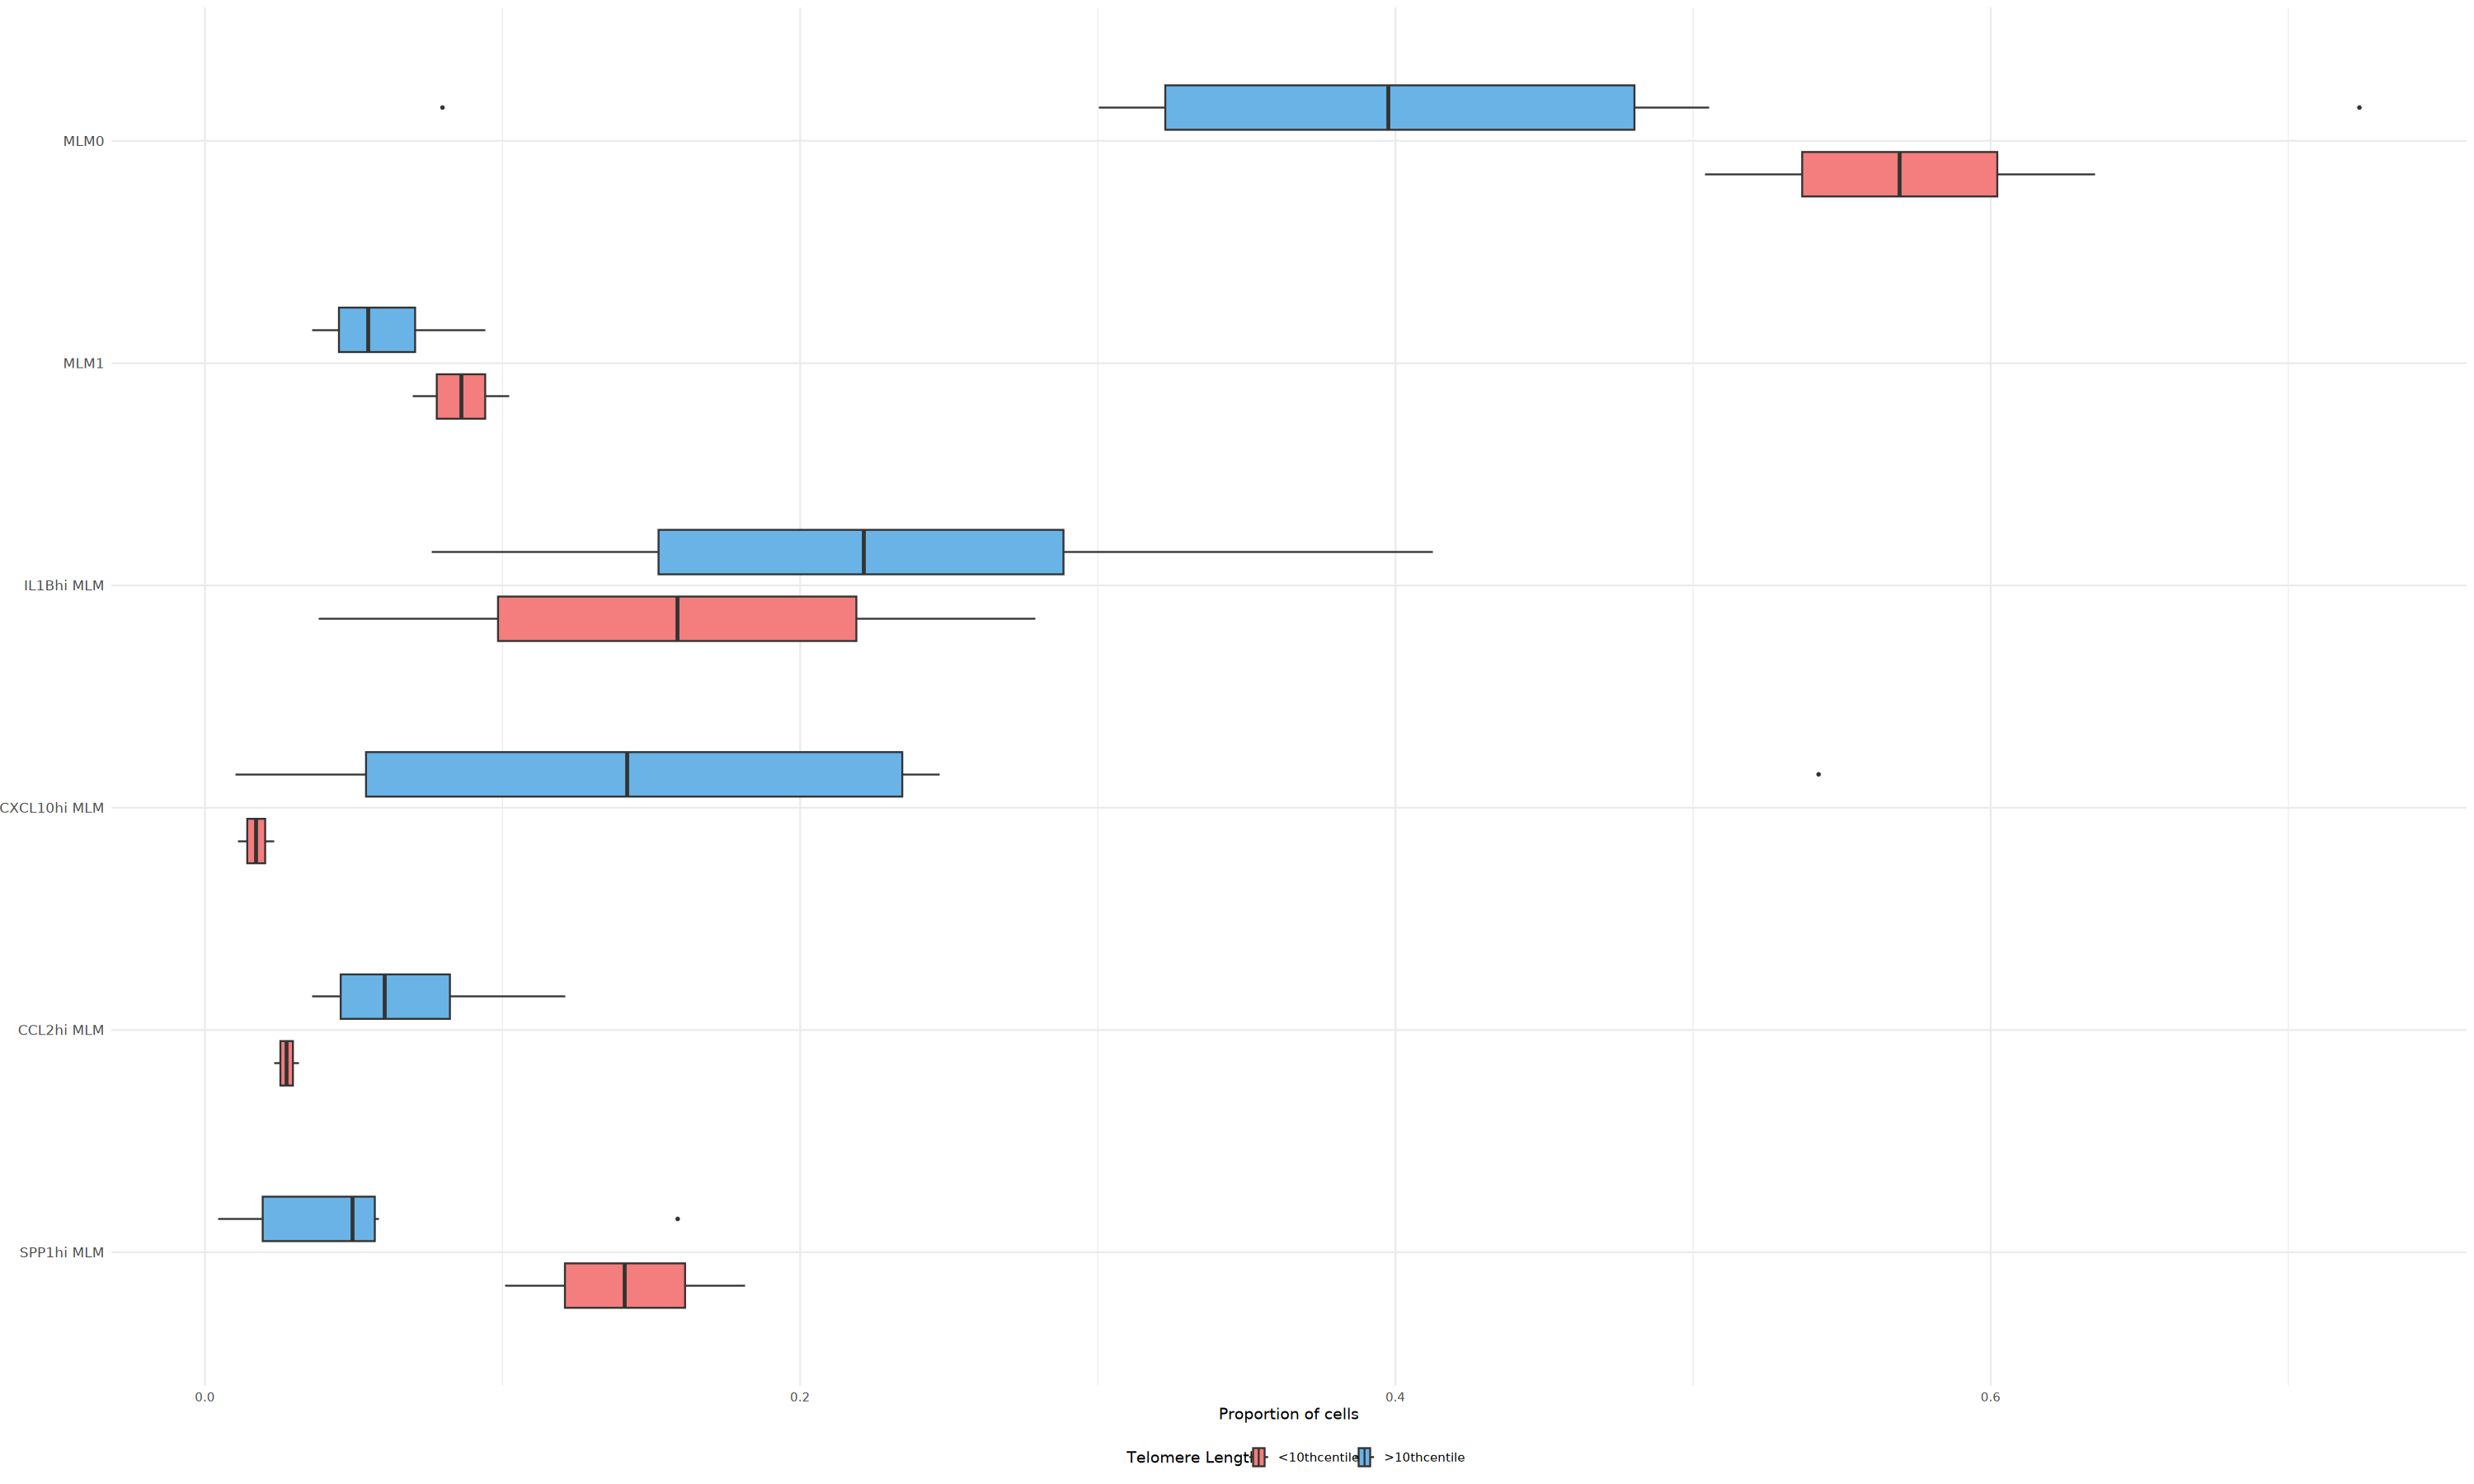

In [6]:
# in IPF only samples:
telo.macs.IPF <- subset(telo.macs, IPF == "IPF")
telo.macs.IPF@meta.data$telomere_length <- droplevels(telo.macs.IPF@meta.data$telomere_length)
metadata <- telo.macs.IPF@meta.data

# Calculate proportion per cell subtype and telomere length group
prop_data <- metadata %>%
  group_by(Sample, telomere_length, Cell_Sub_subtype) %>%
  summarise(count = n(), .groups = "drop") %>%
  group_by(Sample, telomere_length) %>%
  mutate(proportion = count / sum(count)) %>%
  ungroup()

custom_order <- rev(c("MLM0", "MLM1", "IL1Bhi MLM", "CXCL10hi MLM", "CCL2hi MLM", "SPP1hi MLM"))
prop_data$Cell_Sub_subtype <- factor(prop_data$Cell_Sub_subtype, levels = custom_order)

boxplot <- ggplot(prop_data, aes(x = proportion, y = Cell_Sub_subtype, fill = telomere_length)) +
  geom_boxplot(
    width = 0.4,
    position = position_dodge(width = 0.6),
    outlier.size = 0.5
  ) +
  scale_fill_manual(values = c("<10thcentile" = "#f47d7d", ">10thcentile" = "#69b3e7")) +
  theme_minimal() +
  labs(x = "Proportion of cells", y = NULL, fill = "Telomere Length") +
  theme(
    axis.text.y = element_text(size = 10),
    legend.position = "bottom"
  )

print(boxplot)

## Figure 4c: Volcano plot of differential gene expression of the SPP1hi MLM cluster in short versus normal telomere length IPF

,log2foldChange,pValues,FDR
,<dbl>,<dbl>,<dbl>
HLA-DPA1,-1.0559771,7.824578e-23,6.963874e-21
MALAT1,-0.8384589,1.409107e-08,8.360704e-08
LYZ,-0.8269257,3.218235e-14,4.091756e-13
B2M,-0.6858744,9.968924e-19,2.957447e-17
HLA-DRA,-0.6041068,6.228826e-14,6.929569e-13
FN1,-0.5570608,2.027062e-02,3.469395e-02


Warning message:
“Removed 42 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


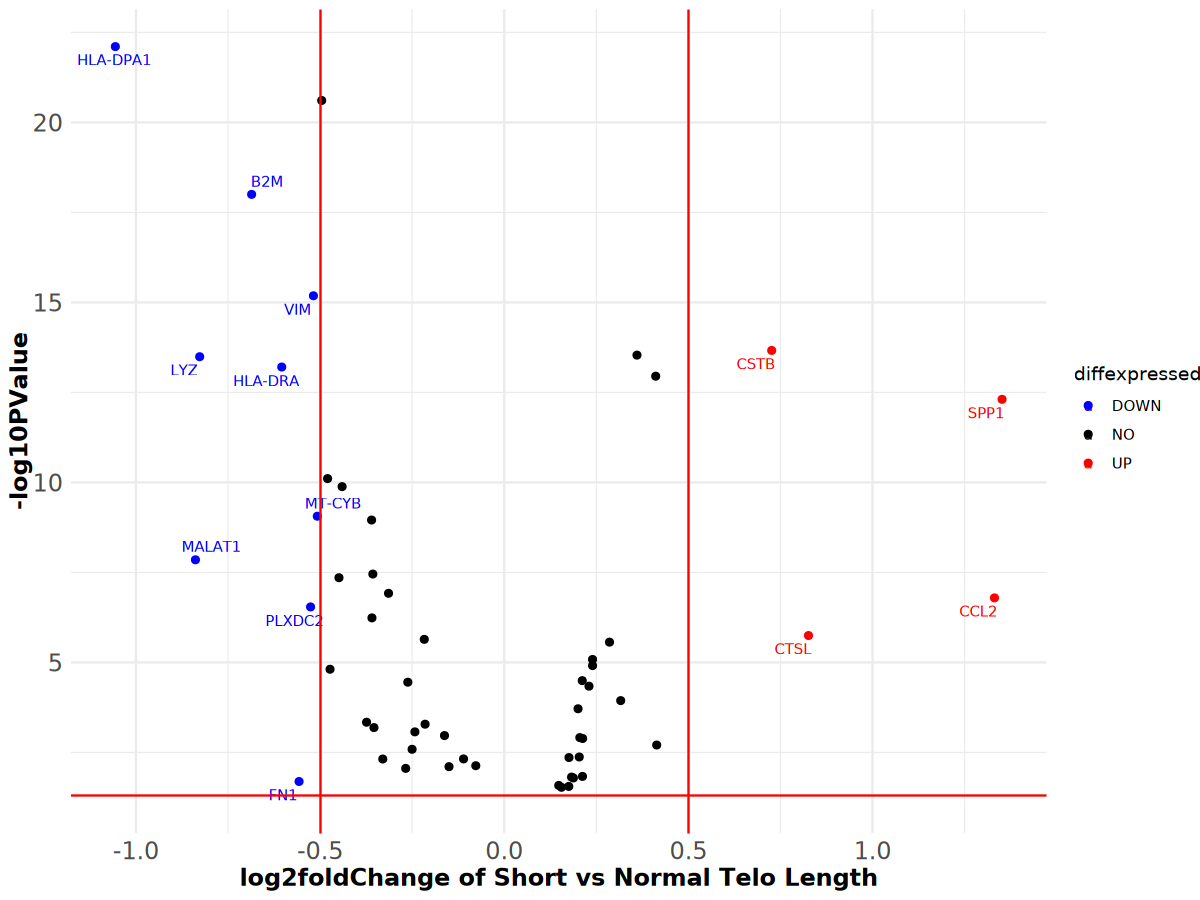

In [7]:
# isolate SPP1hi mlm subcluster as cluster of interest
mdm <- subset(bal, Cell_Subtype == "Monocyte-like macrophage")
mdm1 <- subset(mdm, telomere_length != "NA")
mdm1@meta.data$telomere_length <- droplevels(mdm1@meta.data$telomere_length)
cluster5 <- subset(mdm1, Cell_Sub_subtype == "SPP1hi MLM")

# perform DEG analysis using edgeR
Counts <- cluster5@assays[["RNA"]]$counts
conditions <- data.frame(cluster5@meta.data$telomere_length)
conditions <- t(conditions)
conditions <- factor(t(conditions))

y <- edgeR::DGEList(counts = Counts,group = conditions)
## remove rows that consistently have zero or very low counts
keep <- filterByExpr(y)
y <- y[keep,keep.lib.sizes=FALSE]
## perform TMM normalization and transfer to CPM (Counts Per Million)
y <- calcNormFactors(y,method="TMM")
count_norm = edgeR::cpm(y)
count_norm <- as.data.frame(count_norm)

# run Wilcoxon rank-sum test for each gene
pvalues <- sapply(1:nrow(count_norm),function(i){
     data <- cbind.data.frame(gene=as.numeric(t(count_norm[i,])),conditions)
     p = wilcox.test(gene~conditions, data)$p.value
     return(p)
   })
fdr = p.adjust(pvalues,method = "fdr")

# calculate fold-change for each gene
conditionsLevel <- levels(conditions)
dataCon1 = count_norm[,c(which(conditions == conditionsLevel[1]))]
dataCon2 = count_norm[,c(which(conditions == conditionsLevel[2]))]
foldChanges = log2(rowMeans(dataCon2)/rowMeans(dataCon1))

# output results based on FDR threshold
outRst<-data.frame(log2foldChange=foldChanges, pValues=pvalues, FDR=fdr)
rownames(outRst)=rownames(count_norm)
outRst=na.omit(outRst)
fdrThres=0.05

# making volcano plot:
sorted <- subset(outRst, FDR < 0.05)
sorted <- sorted %>%
    arrange(desc(log2foldChange))
sorted$log2foldChange <- -1 * sorted$log2foldChange
head(sorted)

sorted$diffexpressed <- "NO"
sorted$diffexpressed[sorted$log2foldChange > 0.5 & sorted$FDR < 0.05] <- "UP"
sorted$diffexpressed[sorted$log2foldChange < -0.5 & sorted$FDR < 0.05] <- "DOWN"
sorted$gene_symbol <- rownames(sorted)

sorted$delabel <- NA
sorted$delabel[sorted$diffexpressed != "NO"] <- sorted$gene_symbol[sorted$diffexpressed != "NO"]

plot <- ggplot(data = sorted, aes(x=log2foldChange, y=-log10(pValues), col = diffexpressed, label = delabel)) + 
    geom_point() +
    theme_minimal() + 
    geom_text_repel(size = 3) +
    scale_color_manual(values=c("blue", "black", "red")) +
    geom_vline(xintercept=c(-0.5, 0.5), col = "red") + 
    geom_hline(yintercept = -log10(0.05), col = "red") +
    theme(axis.text=element_text(size=14), axis.title=element_text(size=14,face="bold")) +
    xlab("log2foldChange of Short vs Normal Telo Length") +
    ylab("-log10PValue")

options(repr.plot.width = 10, repr.plot.height = 7.5)
plot